# Introduction

Classification and regression trees (CART)라는 제가 태어난 1984년 [Leo Breiman](https://en.wikipedia.org/wiki/Leo_Breiman),[Jerome Isaac Friedman](https://en.wikipedia.org/wiki/Jerome_Isaac_Friedman), [RICHARD A. OLSHEN
](http://statweb.stanford.edu/~olshen/), 그리고 Charles Stone에 의해서 만들어진 용어로서   Classification Trees 그리고 Regression Trees를 포괄적으로 포함(Umbrella term)하는 용어입니다. 그냥 일반적으로 Decision Tree라고 보통은 말하며, ID3, C4.5, C5.0, CHAID, Decision Stump, M5, Conditional Decision Trees등등.. 정말 다양한 알고리즘이 존재합니다.


Decision tree를 출근이라는 주제로 예를 든다면 다음과 같을 수 있습니다.

In [21]:
%pylab inline
from graphviz import Graph
from IPython.display import Image

Populating the interactive namespace from numpy and matplotlib


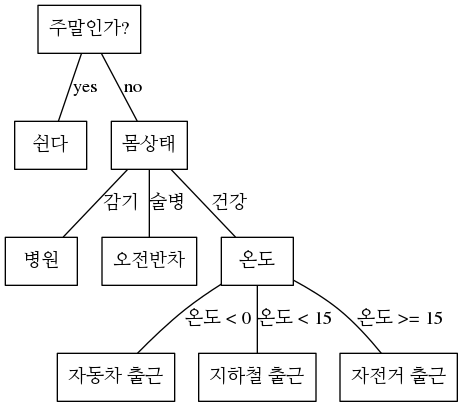

In [24]:
g = Graph('G', format='png')
g.attr('node', shape='box')
g.edge('주말인가?', '쉰다', label='yes')
g.edge('주말인가?', '몸상태', label='no')
g.edge('몸상태', '병원', label='감기')
g.edge('몸상태', '오전반차', label='술병')
g.edge('몸상태', '온도', label='건강')
g.edge('온도', '자동차 출근', label='온도 < 0')
g.edge('온도', '지하철 출근', label='온도 < 15')
g.edge('온도', '자전거 출근', label='온도 >= 15')
Image(g.pipe())

Decision tree 이용하면, 예를 들어서 개발자가 if문등을 사용해서 룰을 만드는 부분을 스스로 룰을 만들고 결정을 내리게 됩니다. 위의 경우 decision tree를 사용해서 classification을 했으며, child nodes가 3개가 나오는 경우가 있는데, 실제 알고리즘에서는 child nodes를 2개만 갖는 binary decision tree를 주로 사용하게 됩니다.

# Information Theory

스무고개를 한다고 가정을 합니다. 0에서부터 1023까지의 숫자중에서 제가 생각하고 있는 숫자 한개를 맞춰보라고 했을때.. 당신의 첫번째 질문은 무엇일까요?

예를 들어, "132입니까?" 라고 물어볼수도 있고, "0에서 100사이의 숫자입니까?" 라고 물어볼수도 있을 것입니다. <br>
하지만 "0에서 511사이의 숫자입니까?"처럼 남아있는 옵션을 절반으로 줄이는 질문이 좋은 질문일 것 입니다. <br>
위의 질문의 경우 {0, ..., 511} 그리고 {512, ..., 1023} 으로 나누며, 어떤 선택을 하든지, 512개의 가능한 값들이 **둘로** 나뉘게 됩니다.

Information Theory에서는 512처럼 남아있는 값을 일종의 **정보**로 보며, entropy라는 컨셉으로 이해를 하게 됩니다.<br>
Entropy는 아주 쉽게 이해했을때, **남아있는 정보의 양**으로 생각하면 쉬우며, 복잡하면 복잡할수록 entropy는 높아지고, 쉽고 명료하다면.. entropy의 양은 줄어들 것 입니다.

숫자로 이해를 해보고자 한다면, 1024를 1빼줘서 bits를 구합니다. (bits로 표현시 0에서부터 시작했을때 0~1023은 1024개와 동일합니다.) 
bits(1023)의 경우 `1111111111`  bit로 표현 될 수 있으며, 10자리의 bits로 구성되어 있기 때문에, 최대 10번의 질문을 해야지만 찾고자 하는 답을 얻을 수가 있게 된다는 뜻이 됩니다. (4는 `bits(3) = 11` 로서 2번 질문이 필요하고, 7의 경우 `bits(6) = 110` 으로서 3번의 질문이 필요합니다.).
다시말하자면, $ \log_2 $ 로 표현이 가능합니다.

| Information | function   | bits       | log_2            | N questions   |
|:------------|:-----------|:-----------|:-----------------|:--------------|
| 1024        | bits(1023) | 1111111111 | $ \log_2(1024) $ | 10 번 질문 필요 | 
| 512         | bits(511)  | 111111111  | $ \log_2(512) $ | 9 번 질문 필요  | 
| 256         | bits(255)  | 11111111   | $ \log_2(256) $ | 8 번 질문 필요  |
| 128         | bits(127)  | 1111111    | $ \log_2(128) $ | 7 번 질문 필요  |
| 64          | bits(63)   | 111111     | $ \log_2(64) $ | 6 번 질문 필요  |
| 32          | bits(31)   | 11111      | $ \log_2(32) $ | 5 번 질문 필요  |
| 16          | bits(15)   | 1111       | $ \log_2(16) $ | 4 번 질문 필요  |
| 8           | bits(7)    | 111        | $ \log_2(8) $ | 3 번 질문 필요  |
| 4           | bits(3)    | 11         | $ \log_2(4) $ | 2 번 질문 필요  |
| 2           | bits(1)    | 1          | $ \log_2(2) $ | 1 번 질문 필요  |


> 물론 0에서 1023의 숫자중에서 첫번째 질문을 `60인가요?`라고 물어봐서 한방에 맞춰버릴수도 있습니다.<br>
> 하지만 이경우 남아있는 정보량을 1023개로 만듬으로서 $ \log_2(1023) = 9.998 $ 로서 질문을 해야 할 횟수를 늘려버리게 됩니다.

결론적으로 Information이란 **우리가 알아내려는 답을 알기까지 필요한 정보의 양 또는 불확실성**이라고 볼 수 있습니다. <br>
예를 들어서 최초 1024에서 답을 알아낼때까지 필요한 정보는 $ \log_2(1024) = 10 $ 이며, <br>
만약 "답이 23인가요?" 처럼 한개를 물어봤을때는 $ \log_2(1023) = 9.99859 $ 가 됩니다. ( $ 1024-1 = 1023 $ )<br>
1~512이 사이의 숫자인가요? 라고 묻게 될 경우 $ \log_2(512) = 9 $ 가 되게 됩니다.

## Impurity Measure

위에서는 설명을 돕기위해서 $ log_2 $ 를 사용한 것이고.. Information equation이 따로 정의가 되어 있습니다.<br>
**Information Equation**은 다음과 같습니다.

$$ I(p) = - \log_b(p) $$

* $ p $ : 는 어떤 이벤트가 일어날 확률
* $ b $ : base 
  * base 2 : bits (보통은 base 2 가 사용됩니다.)
  * base 3 : trits
  * base 10 : Hartleys
  * base e : nats

위의 예제를 다시 Information Equation에 대입하면 다음과 같이 됩니다.

* 1 ~ 512 사이 인가요? : $ - \log_2 \left( \frac{512}{1024} \right) = 1 $
* 답이 24인가요? : $ - \log_2 \left( \frac{1}{1024} \right) = 10  $

1024개의 숫자중에서 1~512처럼 반을 떨궈냈을때의 Information은 1이 되고, 24처럼 하나만 물어보면 10이 됩니다. <br>
즉 찾고자 하는 답을 얻기까지 필요한 정보의 양이 달라지게 됩니다.<br>
다르게 말하자면 **불확실성 (Unpredictability)**을 나타낸다고 볼 수 있습니다. <br>
이 불확실성을 계산하는데 여러가지 방식이 있으며 몇가지 방식을 알아 보도록 하겠습니다.

## Entropy

Entropy는 **불확실성 (Unpredictability)**를 나타냅니다.<br>
예를 들어서 random variable $ X $ 는 룰렛에서 나올수 있는 값을 나타내며, random variable $ Y $ 는 주사위에서 나올수 있는 값을 나타낸다고 했을때, 당연히 $ X $ 의 entropy는 $ Y $ 의 entropy보다 클 것입니다. (주사위는 1~6사이의 숫자가 나올 것이고, 룰렛은 7~36사이의 숫자가 나옵니다.)

Entropy의 수학적 공식은 다음과 같습니다.<br>
Random variable $ X = \{x_1, x_2, ..., x_n \} $ 이며, Probability distribution 은 $ P(X) $ 로 나타낸다고 가정합니다.

$$ I_H(X) = - \sum_{x \in X} p(x) \log p(x) $$

## Maximizing Information Gain

Decision algorithm을 사용시 tree root로 시작을 해서 가장 큰 information gain (IG)값는 feature에서 data를 나누게 됩니다.

# References

* https://webdocs.cs.ualberta.ca/~aixplore/learning/DecisionTrees/InterArticle/4-DecisionTree.html
* http://www.csun.edu/~twang/595DM/Slides/Information%20&%20Entropy.pdf
* https://courses.cs.washington.edu/courses/cse455/10au/notes/InfoGain.pdf